# Nonparametric EM (v1.3)

## Test data

In [116]:
from scipy.stats import multivariate_normal, multinomial
from typing import Tuple
from numpy.random import random_sample, randn
from sklearn.datasets import make_spd_matrix


def make_gmm(n_samples=100, n_features=2,
             n_clusters=3, center_std=10,
             cluster_std=.005, n_symbols=5, weights=None) -> Tuple[np.ndarray, np.ndarray]:

    # pylint: disable=C0103

    if weights is None:
        weights = n_clusters*[1/n_clusters]
    else:
        assert len(weights) == n_clusters

    # Create $n$ multivariate Gaussians
    mvn = [
        multivariate_normal(
            mean=random_sample(n_features),
            cov=make_spd_matrix(n_features) * np.abs(randn(1))*cluster_std
        )
        for i in range(n_clusters)
    ]
    
    P = np.random.dirichlet([1]*n_symbols,n_clusters)
    mn = [
        multinomial(n=1,p=p)
        for p in P
    ]

    # Draw n_samples picks from each of the n_clusters distributions.
    # We will have to discard most of them later (not too efficient)
    rvs_x = np.array([mvn[i].rvs(size=n_samples) for i in range(n_clusters)])
    
    # https://stackoverflow.com/a/42497456
    rvs_s = np.array( [[np.where(r==1)[0][0] for r in i.rvs(size=n_samples)] for i in mn ])
    
    # Damn dimensions never fit. We swap the first two axes afterwards

    # n_samples x n_clusters x n_features
    rvs_x = np.swapaxes(rvs_x, 0, 1)
    rvs_s = rvs_s.T
    


    # Pick samples of the categorical distribution (i.e., multinomial with only 1 draw)

    # n_samples x n_clusters.  One `1.0` per row (all other elements `0.0`)
    idx = multinomial(1, weights).rvs(n_samples)

    # When converted to Booleans, they can be used as an element selector.
    # https://stackoverflow.com/a/23435843
    # Numpy's broadcasting takes care that this works with all values of n_features

    # pylint: disable=comparison-with-callable
    # TODO same pylint bug? Check later https://github.com/PyCQA/pylint/issues/2306
    # n_samples x n_features
    X = rvs_x[idx != 0]
    
    S = rvs_s[idx != 0]

    # From idx, we can get the class labels with a little trick and help from broadcasting
    y = np.sum(np.array([np.arange(n_clusters)]) * idx, 1)

    # Lastly, plot some statistics
    unique, counts = np.unique(y, return_counts=True)
    print(dict(zip(unique, counts)))

    return X,S, y, P

{0: 48, 1: 58, 2: 47, 3: 48, 4: 35, 5: 66, 6: 45, 7: 48, 8: 57, 9: 48}


(500, 2)

(500,)

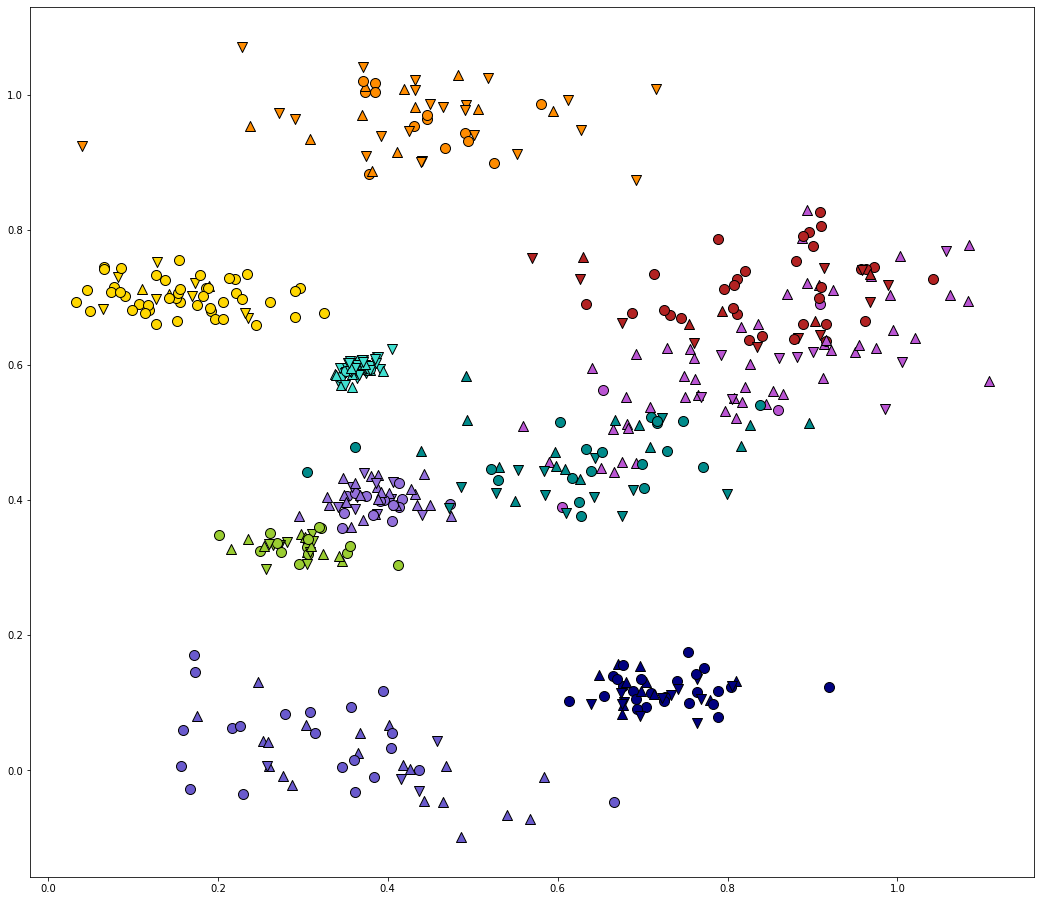

In [236]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

%matplotlib inline 
n_clusters=10
n_symbols=3
X,S,Y,P = make_gmm(500, n_clusters=n_clusters, n_symbols=n_symbols)

symbols=['o','v','^','p','s','P','X','D','>','<']
colors = ['navy', 'turquoise', 'darkorange', 'firebrick',
          'yellowgreen', 'mediumorchid', 'slateblue',
          'darkcyan', 'gold', 'mediumpurple', 'navajowhite']
display(X.shape,S.shape)

f, ax = plt.subplots(1,1, figsize=(18, 16))
for x,s,y in zip(X,S,Y):
    plt.scatter([x[0]], [x[1]], c=colors[y], marker=symbols[s],# c=[y],
                s=100, edgecolor='k')

$$ \begin{array}
{rcl}\lambda_{i,k}^{(j)} &=& \frac{\sum_{t=1}^T \mathbb E [\delta_i(x_t) \delta_k(s_t) | y_{1:T}, \Phi^{(j-1)}] }{a^{(j-1)}} \\
&\approx& \frac{S_{i,k}^{3,(t)}}{ S_i^{0,(t)}}
\end{array} $$

In [120]:
np.random.dirichlet([1]*3,4)

array([[0.719, 0.148, 0.133],
       [0.829, 0.09 , 0.08 ],
       [0.057, 0.93 , 0.013],
       [0.362, 0.348, 0.29 ]])

In [229]:
from typing import List, Optional, Callable, Tuple
import logging
from scipy.stats import multivariate_normal as mvn
from sklearn.datasets import make_spd_matrix
import numpy as np
from numpy.random import random_sample
import attr
from matplotlib import pyplot as plt
import matplotlib as mpl
import sys
import time
from scipy import linalg as scipy_linalg

from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
    _compute_log_det_cholesky
)
from kuberspatiotemporal.tools import (
    check_spd, 
    check_singular,
    make_ellipses,
    repr_list_ndarray
)

%matplotlib inline

# Always useful: https://stackoverflow.com/a/44401529
logging.basicConfig(format='[%(funcName)s:%(lineno)d] %(message)s')
logger = logging.getLogger(__name__)

logger.setLevel(logging.DEBUG)
    
##################
# tools.py
##################

def repr_ndarray(x: np.ndarray) -> str:
    return f"Array {x.shape}" if x is not None else "None"


def cholesky_precisions(x: np.ndarray) -> Tuple[np.ndarray,np.ndarray]:
    n_components, n_features, _ = x.shape
    
    precisions_chol = np.empty((n_components, n_features, n_features))
    for k, covariance in enumerate(x):
        try:
            cov_chol = scipy_linalg.cholesky(covariance, lower=True)
            # cov_chol2 = np.linalg.cholesky(covariance)
            # assert np.allclose(cov_chol,cov_chol2)
        except scipy_linalg.LinAlgError:
            raise ValueError("Could not invert")
        precisions_chol[k] = scipy_linalg.solve_triangular(cov_chol,
                                                     np.eye(n_features),
                                                     lower=True).T # cannot be vectorized :(
        
        
    
    n_components, _, _ = precisions_chol.shape
    log_det_chol = (np.sum(np.log(
        precisions_chol.reshape(
            n_components, -1)[:, ::n_features + 1]), 1))
    return precisions_chol, log_det_chol


##################
# dpm.py
##################

@attr.s
class GaussianMixtureModel:

    # public attributes
    n_components: int = attr.ib()
    n_dim: int = attr.ib(default=2)
    alpha: float = attr.ib(default=0.75)
    start_maximimization: int = attr.ib(default=5)
    nonparametric: bool = attr.ib(default=True)
    scaling_parameter: float = attr.ib(default=2.0)

    # Internal state variables
    counter: int = attr.ib(default=0)  # This is intended for resuming / incremental
    priors: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    weights: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    means: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    covs: Optional[np.ndarray] = attr.ib(default=None, repr=repr_ndarray)
    sufficient_statistics: List[np.ndarray] = attr.ib(factory=list, repr=lambda x: repr_list_ndarray)
    cached_regularization: Optional[np.ndarray] = attr.ib(default=None, repr=False)
    limits: Tuple[np.ndarray,np.ndarray] = attr.ib(default=None) # should have a validator
    min_eigval: float = attr.ib(default=1e-2)

    # To compare new implementation with legacy code + time measurements
    compare_expects: bool = attr.ib(default=False)
    
    alternator: int = attr.ib(default=0)
        
    # for symbolic:
    n_symbols: int = attr.ib(default=5) # CATEGORICAL
    pmf: Optional[np.ndarray] = attr.ib(default=None)
   
    def __attrs_post_init__(self):
        if self.limits is None:
            self.limits = (np.zeros(self.n_dim),np.ones(self.n_dim))
            

        if self.means is None:
            # (b - a) * random_sample() + a
            self.means = (
                (self.limits[1]-self.limits[0]) 
                * np.random.random((self.n_components, self.n_dim,)) 
                + self.limits[0]
            )
            
        if self.covs is None:
             self.covs =  ( 
                 np.tile(np.identity(self.n_dim),(self.n_components,1,1)) 
                 * np.random.rand(self.n_components)[:,np.newaxis,np.newaxis]  #(1/self.n_components)
                 *10
             )
                                                                                
        if not self.sufficient_statistics:
            self.sufficient_statistics = [
                np.zeros((self.n_components,)),
                np.zeros((self.n_components, self.n_dim)),
                np.zeros((self.n_components, self.n_dim, self.n_dim)),
                np.zeros((self.n_components, self.n_symbols)) # CATEGORICAL
            ]    
            
        if self.pmf is None:
            self.pmf = np.random.dirichlet([1]*n_symbols,self.n_components)
            
        if self.priors is None:
            self.priors = np.random.beta(1,self.scaling_parameter,(self.n_components,))
            self.priors[-1] = 1.0 # truncate
        
        if self.weights is None:
            if not self.nonparametric:
                self.weights = np.ones((self.n_components,)) * 1.0 / self.n_components
                print('Noope')
            else:
                self.weights = self.stick_breaking()

        
        if self.cached_regularization is None:
            self.cached_regularization = np.identity(self.n_dim)*1e-6
            
        logger.info('GMM initiailized')

    def stick_breaking(self)->np.ndarray:
        weights = np.empty(self.priors.shape)
        self.priors[-1] = 1.0 # truncate
        
        weights[0] = self.priors[0]
        weights[1:] = self.priors[1:] * np.cumprod(1 - self.priors)[:-1]
        
        return weights
        
        
    def reset(fancy_index: np.ndarray, randomize=False):
        # Rename to reset, and add a parameter for 
        
        #Weights are to be set in detect
        #self.weights[fancy_index] = 1 / self.n_components 
        #self.weights /= np.sum(self.weights)
        
        if randomize:
            self.means[fancy_index] = (
                (self.limits[1]-self.limits[0]) 
                * np.random.random((self.n_components, self.n_dim,)) 
                + self.limits[0])[fancy_index]
            self.covs[fancy_index] = np.identity(self.n_dim)
        else:
            pass

    
    
    def predict(self, data: np.ndarray,symbols: np.ndarray) -> np.ndarray:
        responsibilities = np.asarray(self.expect(data,symbols))
        return np.argmax(responsibilities,axis=1), responsibilities
    
    def expect(self, data: np.ndarray, symbols: np.ndarray) -> List[List[float]]:
    

        start = time.time()

        n_samples = data.shape[0]
        
        # precisions = _compute_precision_cholesky(self.covs,'full') 
        # log_det = _compute_log_det_cholesky(precisions,'full', self.n_dim)
        precisions, log_det = cholesky_precisions(self.covs)
        
        # n - n_samples, d/e - n_dim, c - n_components
        log_prob = np.sum(np.square(
            np.einsum('nd,cde->nce', data, precisions) - 
            np.einsum('cd,cde->ce', self.means, precisions)[np.newaxis,:,:]), 
            axis=2)
       
        
        # weights can / should be zero (caught degenerates)
        with np.errstate(divide='ignore',invalid='ignore'): 

            weighted_prob = np.exp(
                -.5 * (self.n_dim * np.log(2 * np.pi) + log_prob) 
                + log_det + np.log(self.weights)[np.newaxis,:]
            )
        
            weighted_prob *= self.pmf[:,symbols.astype(int)].T # CATEGORICAL
            
        
            responsibilities = weighted_prob / np.sum(weighted_prob, axis=1)[:,np.newaxis]
            
            
            responsibilities[np.isnan(responsibilities)] = 0

        
        if self.compare_expects:
            logger.info('Time spent: %s',time.time() - start)

        return responsibilities


        
        
    def maximize(self):

        
        if not self.nonparametric:
            self.weights = self.sufficient_statistics[0] / np.sum(self.sufficient_statistics[0])
        else:
#             logger.debug('before: %s', np.sort(self.weights))
            with np.errstate(divide='ignore',invalid='ignore'): 

                self.priors = self.sufficient_statistics[0] / ( 
                    self.scaling_parameter - 1 + np.flip(np.cumsum(np.flip(self.sufficient_statistics[0]))) 
                )
                self.priors[np.isnan(self.priors)] = 0.0
#                 assert np.all(self.priors>=0), f"priors {self.priors}"


            self.weights = self.stick_breaking()



                
            
        ########################################

        # suppress div by zero warinings (occur naturally for disabled components)


        
        with np.errstate(divide='ignore',invalid='ignore'): 

            self.means = self.sufficient_statistics[1] / self.sufficient_statistics[0][:, np.newaxis]

            self.covs = (
                self.sufficient_statistics[2] / self.sufficient_statistics[0][:, np.newaxis, np.newaxis]
                - np.einsum('ki,kj->kij', self.means, self.means)
            )  + self.cached_regularization[np.newaxis,:,:]

            self.pmf = self.sufficient_statistics[3] / self.sufficient_statistics[0][:,np.newaxis]

    def find_degenerated(self, method='eigen', remove=True):
        '''Remove irrelevant components'''
        
        if method=='eigen':
            self.covs[np.any(np.isnan(self.covs),axis=1)] = 0
            irrelevant = np.min(np.linalg.eigvals(self.covs),axis=1) < self.min_eigval
            
        elif method=='count':
            # In batch, self.sufficient_statistics is almost equal to self.counter
            # So we can estimate the number of points for each component and remove
            # those with less than enogh points (n+1, e.g., 3 points required in 2D 
            # as 2D only spans a line)
            # In incremental, the original assumption does not hold
            irrelevant = self.weights < (self.n_dim+1) / np.sum(self.sufficient_statistics[0]) 

        if remove:
            self.priors[irrelevant] = 0.0
            self.means[irrelevant] = 0
            self.covs[irrelevant] = np.identity(self.n_dim) * 1e-2
            self.pmf[irrelevant] = 0
        else:
            raise NotImplemented

        if self.nonparametric:
            self.weights=self.stick_breaking()
        else:
            self.weights[irrelevant] = 0.0
            self.weights /= np.sum(self.weights)

        return np.sum(irrelevant)

    
    
    def batch(self, data: np.ndarray, symbols: np.ndarray):

        n_samples = data.shape[0]
        self.counter = n_samples
        
        responsibilities = np.asarray(self.expect(data, symbols))

        
        self.sufficient_statistics[0] = np.sum(
            responsibilities,  # (n_samples, n_components)
            axis=0
        )

        self.sufficient_statistics[1] = np.sum(
            responsibilities[:, :, np.newaxis] * data[:, np.newaxis, :],  # (n_samples, n_components, n_dim)
            axis=0
        )

        self.sufficient_statistics[2] = np.sum(
            responsibilities[:, :, np.newaxis, np.newaxis] *
            np.einsum('Ti,Tj->Tij', data, data)[:, np.newaxis, :, :],  # (n_samples, n_components, n_dim, n_dim)
            axis=0
        )
        
        #   CATEGORICAL
        temp = np.zeros((n_samples, self.n_components, self.n_symbols))
        temp[np.arange(n_samples),:,symbols.astype(int)] = responsibilities
        self.sufficient_statistics[3] = np.sum(temp,axis=0)

        self.maximize()
        d=self.find_degenerated()
#         logger.debug("Detected %d degenerated", d)
        


    def incremental(self, data: np.ndarray, symbols: np.ndarray):

        if self.counter == 0:
            self.sufficient_statistics[0] = (
                self.weights * 10
            )

            self.sufficient_statistics[1] = (
                self.sufficient_statistics[0][:,np.newaxis] * self.means
            )

            self.sufficient_statistics[2] = (
                self.sufficient_statistics[0][:,np.newaxis,np.newaxis] * 
                ( self.covs +
                np.einsum('ki,kj->kij', means, means) )
            ) 
            self.counter = 10
            
        logger.debug("%s, %f,%f,%f",self.sufficient_statistics[0]/np.sum(self.sufficient_statistics[0]),
                     np.sum(self.sufficient_statistics[0]),
                     (self.counter)**(-self.alpha),((self.counter)**(-self.alpha))**100)

        degs=0
        for sample, symb in zip(data, symbols):
            
            self.counter += 1

            responsibilities = np.asarray(self.expect(sample.reshape(1, -1))).reshape(-1)

            rate = (self.counter)**(-self.alpha)

            # First reduce the influence of the older samples
            for i in self.sufficient_statistics:
                i *= (1-rate)

            # Then introduce the new sample
            self.sufficient_statistics[0] += (
                rate * responsibilities
            )

            self.sufficient_statistics[1] += (
                rate * responsibilities[:, np.newaxis] * sample[np.newaxis, :]
            )

            self.sufficient_statistics[2] += (
                rate * responsibilities[:, np.newaxis, np.newaxis] *
                np.einsum('i,j->ij', sample, sample)[np.newaxis, :, :]
            )
            
            #   CATEGORICAL
            temp = np.zeros((n_samples, self.n_components, self.n_symbols))
            temp[np.arange(n_samples),:,symbols.astype(int)] = responsibilities
            self.sufficient_statistics[3] = np.sum(temp,axis=0)

            self.maximize()
            d = self.find_degenerated()
            if d!=degs:
                logger.debug("Detected %d degenerated", degs)
                degs=d
        logger.debug("Finished. Detected %d degenerated", degs)

    def fit(self, data: np.ndarray, symbols: np.ndarray, n_iterations=100, online=False):

        if len(data.shape) != 2:
            raise ValueError(f"Wrong input dimensions (at least 2D)")

        if data.shape[1] != self.n_dim:
            raise ValueError(f"Wrong input dimensions {data.shape[1]} != {self.n_dim} ")

        if data.shape[0] == 0:
            logger.info("Empty data set")
            return
        logger.info("Learning %d samples (%s)", data.shape[0],
                     "Online" if online else "Batch")

        for i in range(n_iterations):
            if i % 10 == 0:
                logger.info('Step %d/%d, %d degerates', i, n_iterations, self.find_degenerated())
#                 logger.info(self.pmf)
            if online:
                self.incremental(data, symbols)
            else:
                self.batch(data, symbols)

    def get_logger(self):
        return logger
            
            

[__attrs_post_init__:146] GMM initiailized
[fit:398] Learning 500 samples (Batch)
[fit:402] Step 0/150, 0 degerates
[fit:402] Step 10/150, 0 degerates
[fit:402] Step 20/150, 0 degerates
[fit:402] Step 30/150, 0 degerates
[fit:402] Step 40/150, 0 degerates
[fit:402] Step 50/150, 0 degerates
[fit:402] Step 60/150, 0 degerates
[fit:402] Step 70/150, 0 degerates
[fit:402] Step 80/150, 0 degerates
[fit:402] Step 90/150, 0 degerates
[fit:402] Step 100/150, 0 degerates
[fit:402] Step 110/150, 0 degerates
[fit:402] Step 120/150, 0 degerates
[fit:402] Step 130/150, 0 degerates
[fit:402] Step 140/150, 0 degerates
[__attrs_post_init__:146] GMM initiailized
[fit:398] Learning 500 samples (Batch)
[fit:402] Step 0/150, 0 degerates


[[0.487 0.289 0.224]
 [0.022 0.794 0.184]
 [0.248 0.638 0.114]
 [0.632 0.264 0.104]
 [0.367 0.345 0.288]
 [0.08  0.108 0.813]
 [0.527 0.084 0.388]
 [0.479 0.278 0.244]
 [0.664 0.28  0.056]
 [0.29  0.197 0.513]]
[[0.279 0.485 0.236 0.    0.   ]
 [0.552 0.352 0.096 0.    0.   ]
 [0.467 0.089 0.444 0.    0.   ]
 [0.81  0.138 0.052 0.    0.   ]
 [0.354 0.25  0.396 0.    0.   ]
 [0.444 0.    0.556 0.    0.   ]
 [0.447 0.553 0.    0.    0.   ]
 [0.263 0.34  0.397 0.    0.   ]]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0. 

[fit:402] Step 10/150, 0 degerates
[fit:402] Step 20/150, 0 degerates
[fit:402] Step 30/150, 0 degerates
[fit:402] Step 40/150, 0 degerates
[fit:402] Step 50/150, 0 degerates
[fit:402] Step 60/150, 0 degerates
[fit:402] Step 70/150, 0 degerates
[fit:402] Step 80/150, 0 degerates
[fit:402] Step 90/150, 0 degerates
[fit:402] Step 100/150, 0 degerates
[fit:402] Step 110/150, 0 degerates
[fit:402] Step 120/150, 0 degerates
[fit:402] Step 130/150, 0 degerates
[fit:402] Step 140/150, 0 degerates


[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.002 0.021 0.069 0.069 0.086
 0.092 0.096 0.111 0.454]


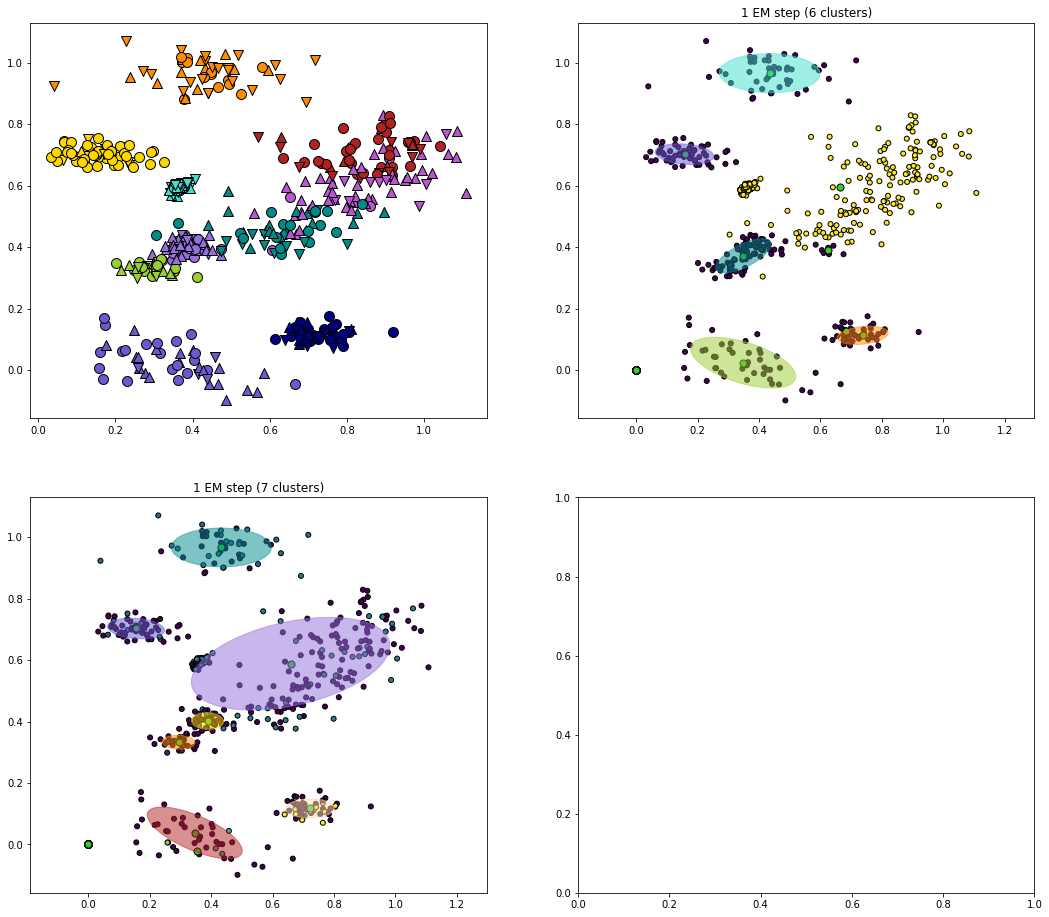

In [239]:
f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(18, 16))

np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

np.seterr(divide='print')

gmm = GaussianMixtureModel(n_components=1000, nonparametric=True, 
                           scaling_parameter=2,compare_expects=False, 
                           limits=np.array([[0,0],[1,1]]),
                           min_eigval=1e-4
                          )

for x,s,y in zip(X,S,Y):
    ax1.scatter([x[0]], [x[1]], c=colors[y], marker=symbols[s],# c=[y],
                s=100, edgecolor='k')

gmm.fit(X,S,n_iterations=150)
make_ellipses(gmm, ax2, min_weight=0.05)

means = np.asarray(gmm.means)

y_,s_ = gmm.predict(X,S)
ax2.scatter(X[:, 0], X[:, 1], marker='o', c=y_,
            s=25, edgecolor='k')

ax2.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
            s=50, edgecolor='k')
ax2.set_title(f'1 EM step ({np.sum(gmm.weights > 0.05)} clusters)')
    
print(P)
print(gmm.pmf[np.any( gmm.pmf != 0, axis=1)])

print(np.sort(gmm.weights))


gmm = GaussianMixtureModel(n_components=100, nonparametric=True, 
                           scaling_parameter=2,compare_expects=False, 
                           limits=np.array([[0,0],[1,1]]),
                           min_eigval=1e-4
                          )
gmm.fit(X,np.ones(X.shape[0]),n_iterations=150)

make_ellipses(gmm, ax3, min_weight=0.05)

means = np.asarray(gmm.means)




y_,s_ = gmm.predict(X,S)
ax3.scatter(X[:, 0], X[:, 1], marker='o', c=y_,
            s=25, edgecolor='k')

ax3.scatter(means[:, 0], means[:, 1], marker='o', c='limegreen',
            s=50, edgecolor='k')
ax3.set_title(f'1 EM step ({np.sum(gmm.weights > 0.05)} clusters)')
    
print(gmm.pmf[np.any( gmm.pmf != 0, axis=1)])

print(np.sort(gmm.weights))


    

Doesn't look terribly different. Understandably, as the following thought shows.
Given two components with exactly the same 2D coordinates $P_1^{loc}=P_2^{loc}$ but
different categorical mass distributions: $P_1^{cat} \neq P_2^{cat}$ 

$$ \begin{array}{rcl}
P(y|\Phi) &=& \pi_1 \cdot P_1^{loc} P_1^{cat} + \pi_2 \cdot  P_2^{loc} \cdot P_2^{cat} \\
&=& P_1^{loc} \cdot \left( \pi_1  \cdot  P_1^{cat} + \pi_2 \cdot P_2^{cat} \right) 
\end{array}$$

which hints at why it is that clusters with similar locations merge despite different 
categorical distributions. This changes, however, as soon as a second distribution is introduced(?)

In [232]:
0.0

0.0015